# Проект: Прогноз расхода энергии по временным рядам
Этот ноутбук содержит пошаговое руководство для решения задачи прогнозирования потребления энергии с использованием временных рядов. Мы будем использовать набор данных PJM Hourly Energy Consumption, предоставленный на Kaggle

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
import scipy.stats as stats
from scipy.stats import shapiro
import statsmodels.api as sm
from statsmodels.formula.api import ols

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from datetime import datetime, timedelta

from joblib import Parallel, delayed
import itertools
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import  mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

import time


from prophet import Prophet
from matplotlib.ticker import FuncFormatter

In [2]:
# Функция теста Дики-Фуллера с ACF и PACF 
def Dickey_Fuller_test_with_acf_pacf_sns(data: pd.Series):
    """
    Расширенный тест Дики-Фуллера на стационарность ряда.
    
    Аргументы:
        data (pd.Series): данные 
        
    Возвращает:
        data (pd.Series): дифференцированные данные
        diff_order (int): порядок дифференцирования
    """
    diff_order = 0  # Начальный порядок дифференцирования
    
    while True:
        test_result = adfuller(data)
        
        if test_result[0] > test_result[4]['5%']:
            data = data.diff().dropna()  # Применяем дифференцирование
            diff_order += 1
            print(f'Попытка {diff_order}: ряд нестационарен')
        else:
            print("ADF Statistic: {:.2f}".format(test_result[0]))
            print("p-value: {:.2g}".format(test_result[1]))
            print("Критические значения:")
            for key, value in test_result[4].items():
                print(f"\t{key}: {value:.3f}")
            print(f'Ряд стационарен\nПорядок дифференцирования = {diff_order}')
            
            
            break
        
    return data, diff_order


# Загрузка данных и первичный анализ

In [3]:
pjme_df = pd.read_csv('data/hourly-energy-consumption/PJME_hourly.csv')

In [4]:
# Преобразование столбца времени в формат datetime
pjme_df['Datetime'] = pd.to_datetime(pjme_df['Datetime'])

In [5]:
pjme_df.describe()

,Datetime,PJME_MW
count,145366,145366.000000
mean,2010-04-18 03:25:25.999202048,32080.222831
min,2002-01-01 01:00:00,14544.000000
25%,2006-02-23 14:15:00,27573.000000
50%,2010-04-18 04:30:00,31421.000000
75%,2014-06-10 18:45:00,35650.000000
max,2018-08-03 00:00:00,62009.000000
std,NaN,6464.012166


In [6]:
pjme_df.isnull().sum()

Datetime    0
PJME_MW     0
dtype: int64

In [7]:
pjme_df.duplicated().sum()

0

### Проверка временных промежутков:

In [8]:
# Выявление пропущенных временных меток
all_dates = pd.date_range(start=pjme_df['Datetime'].min(), end=pjme_df['Datetime'].max(), freq='H')
missing_dates = all_dates.difference(pjme_df['Datetime'])
print(f"Пропущенные временные метки: {len(missing_dates)}")


Пропущенные временные метки: 30


C:\Users\mazur\AppData\Local\Temp\ipykernel_22936\3039074270.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  all_dates = pd.date_range(start=pjme_df['Datetime'].min(), end=pjme_df['Datetime'].max(), freq='H')


In [9]:
# Преобразуем столбец 'Datetime' в индекс для сравнения
actual_dates = pd.DatetimeIndex(pjme_df['Datetime'])

# Найдём пропущенные даты
missing_dates = all_dates.difference(actual_dates)

# Вывод количества пропущенных временных меток и самих дат
print(f"Количество пропущенных временных меток: {len(missing_dates)}")
print(f"Пропущенные временные метки: {missing_dates}")

Количество пропущенных временных меток: 30
Пропущенные временные метки: DatetimeIndex(['2002-04-07 03:00:00', '2002-10-27 02:00:00',
               '2003-04-06 03:00:00', '2003-10-26 02:00:00',
               '2004-04-04 03:00:00', '2004-10-31 02:00:00',
               '2005-04-03 03:00:00', '2005-10-30 02:00:00',
               '2006-04-02 03:00:00', '2006-10-29 02:00:00',
               '2007-03-11 03:00:00', '2007-11-04 02:00:00',
               '2008-03-09 03:00:00', '2008-11-02 02:00:00',
               '2009-03-08 03:00:00', '2009-11-01 02:00:00',
               '2010-03-14 03:00:00', '2010-11-07 02:00:00',
               '2010-12-10 00:00:00', '2011-03-13 03:00:00',
               '2011-11-06 02:00:00', '2012-03-11 03:00:00',
               '2012-11-04 02:00:00', '2013-03-10 03:00:00',
               '2013-11-03 02:00:00', '2014-03-09 03:00:00',
               '2015-03-08 03:00:00', '2016-03-13 03:00:00',
               '2017-03-12 03:00:00', '2018-03-11 03:00:00'],
            

Список пропущенных временных меток указывает на то, что многие из них совпадают с переходом на летнее и зимнее время. Пропуски во временных рядах часто случаются в такие моменты, поскольку час "теряется" при переходе на летнее время (например, в 03:00) и может "дублироваться" при переходе на зимнее (например, в 02:00).

Поскольку пропуски связаны с переходом на летнее и зимнее время, и это повторяющиеся сезонные явления, их можно оставить как есть. Это естественная часть данных о временных рядах, особенно когда мы работаем с временными рядами энергопотребления.

# Анализ и визуализация данных (EDA)

## Визуализация данных


#### Временной ряд энергопотребления: Построим график энергопотребления по времени.

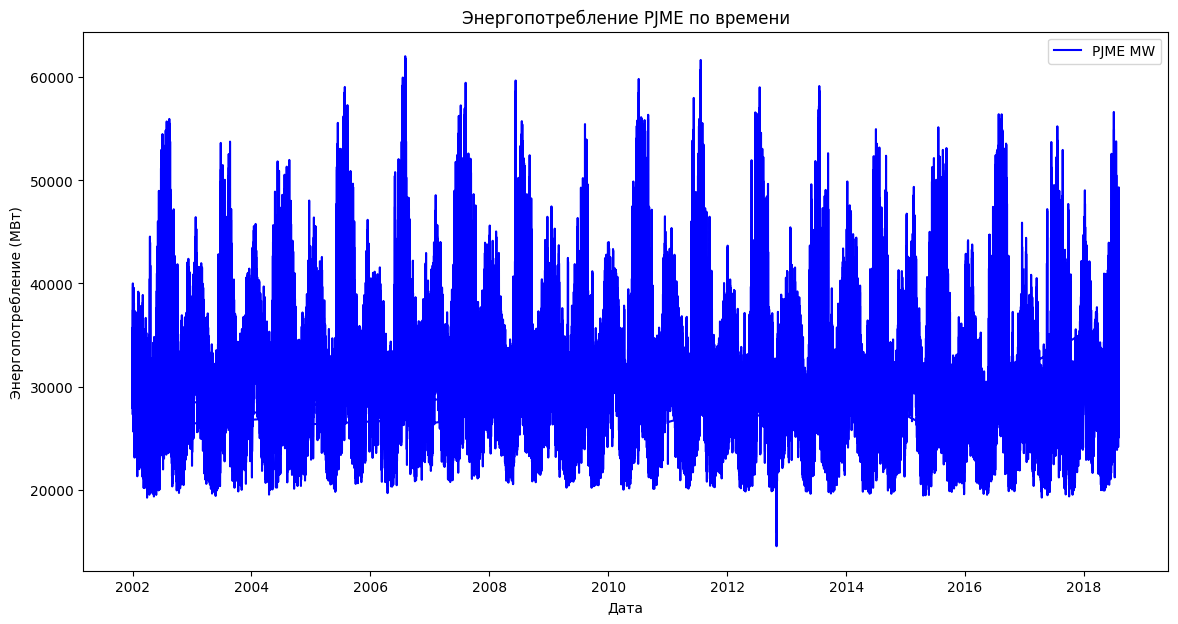

In [10]:
plt.figure(figsize=(14, 7))
plt.plot(pjme_df['Datetime'], pjme_df['PJME_MW'], label='PJME MW', color='blue')
plt.xlabel('Дата')
plt.ylabel('Энергопотребление (МВт)')
plt.title('Энергопотребление PJME по времени')
plt.legend()
plt.show()


Вывод по графику энергопотребления PJME:

На графике представлено энергопотребление PJME с почасовой детализацией за период с 2002 по 2018 год. Чётко видны следующие закономерности:

1. **Сезонные колебания**:
   - На графике заметны регулярные годовые циклы, которые указывают на наличие выраженной сезонности в потреблении энергии. Пики энергопотребления, скорее всего, связаны с летними и зимними периодами, когда потребление энергии возрастает из-за использования кондиционеров и отопительных систем.

2. **Долгосрочные тренды**:
   - Несмотря на сезонные колебания, на графике виден общий тренд с некоторыми отклонениями в разные периоды времени. Это может быть связано с экономическими и климатическими изменениями, которые влияют на долгосрочные изменения энергопотребления.

3. **Аномальные точки**:
   - На графике также присутствуют несколько аномальных точек с резким падением энергопотребления (например, в 2012 году), которые могут быть результатом внешних факторов, таких как сбои в энергосистеме или природные явления.

Заключение:
Потребление энергии PJME демонстрирует чёткую сезонную структуру, что необходимо учитывать при дальнейшем анализе и прогнозировании. Также стоит провести детальный анализ аномалий, чтобы понять их природу.


In [11]:
pjme_df.query('PJME_MW < 19000')

,Datetime,PJME_MW
89091,2012-10-31 02:00:00,18618.0
89092,2012-10-31 03:00:00,18350.0
89093,2012-10-31 04:00:00,18330.0
89094,2012-10-31 05:00:00,18880.0
89114,2012-10-30 01:00:00,15390.0
89115,2012-10-30 02:00:00,14955.0
89116,2012-10-30 03:00:00,14586.0
89117,2012-10-30 04:00:00,14544.0
89118,2012-10-30 05:00:00,14821.0
89119,2012-10-30 06:00:00,15526.0


Судя по приведённым данным, выбросы можно заметить в области значений энергопотребления, где оно резко снижается, особенно в период 29-31 октября 2012 года. Эти данные показывают значительное снижение энергопотребления, особенно в ранние часы 30 октября, что может быть аномальным событием.

В конце октября 2012 года произошёл ураган "Сэнди", который сильно повлиял на энергетическую инфраструктуру США, особенно на восточном побережье, что может объяснить резкое снижение потребления в этот период.
Оставить выбросы как есть:

Скорее всего выбросы связаны с реальными событиями (например, ураганом "Сэнди"), имеет смысл оставить их в данных, поскольку они могут быть важны для анализа редких, но значимых явлений.


#### Распределение потребления энергии: Построим гистограмму для визуализации распределения значений.

c:\Users\mazur\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


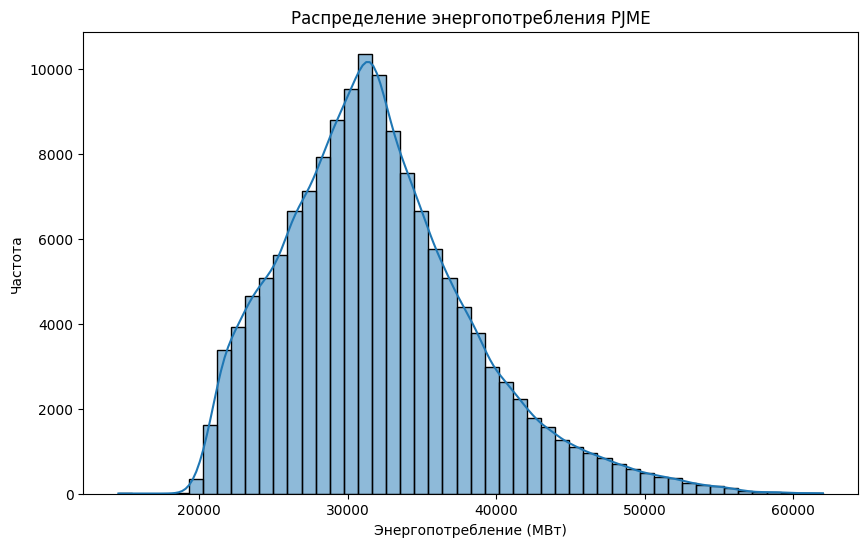

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(pjme_df['PJME_MW'], bins=50, kde=True)
plt.title('Распределение энергопотребления PJME')
plt.xlabel('Энергопотребление (МВт)')
plt.ylabel('Частота')
plt.show()


Вывод по графику распределения энергопотребления PJME:

1. **Форма распределения**:
   - Распределение энергопотребления PJME не является симметричным — оно смещено вправо. Это указывает на то, что большинство значений энергопотребления сконцентрированы в диапазоне от 25,000 до 35,000 МВт, но существуют выбросы с более высокими значениями потребления (до 60,000 МВт).
   - Распределение похоже на логнормальное, с длинным хвостом в сторону более высоких значений потребления.

2. **Мода (наиболее частое значение)**:
   - Самое частое значение потребления находится около **30,000 МВт**, что свидетельствует о типичном уровне энергопотребления для большинства дней в регионе PJME.

3. **Выбросы**:
   - На графике видно, что есть небольшое количество данных, которые сильно превышают основную массу значений (выбросы на уровне более 50,000 МВт). Эти значения могут быть связаны с периодами пикового спроса, например, в летние или зимние месяцы, когда энергопотребление увеличивается из-за экстремальных температур.

4. **Широкий диапазон значений**:
   - Энергопотребление варьируется от значений ниже 20,000 МВт до пиковых значений более 60,000 МВт, что отражает высокую изменчивость спроса в зависимости от времени года, дня недели и других факторов.

Заключение:
Распределение энергопотребления PJME смещено вправо и имеет широкий диапазон значений. Основное потребление сосредоточено около 30,000 МВт, однако есть периодические пики, которые могут быть связаны с экстремальными погодными условиями или периодами высокого спроса. Для дальнейшего анализа можно исследовать выбросы, а также возможные факторы, влияющие на высокие значения энергопотребления.


### Анализ сезонности


#### Среднее энергопотребление по месяцам:

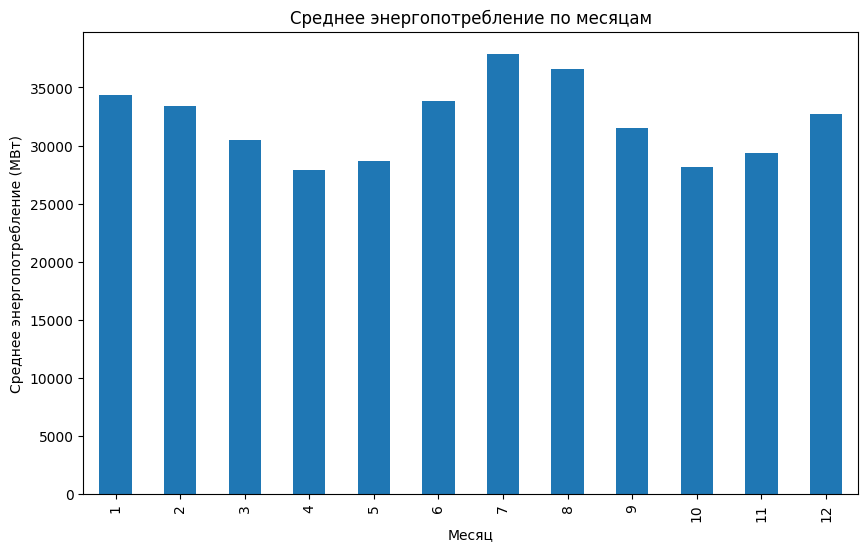

In [13]:
# Создание новых признаков
pjme_df['Year'] = pjme_df['Datetime'].dt.year
pjme_df['Month'] = pjme_df['Datetime'].dt.month
pjme_df['DayOfWeek'] = pjme_df['Datetime'].dt.dayofweek  # 0: Понедельник, 6: Воскресенье
pjme_df['Hour'] = pjme_df['Datetime'].dt.hour

# Среднее энергопотребление по месяцам
monthly_mean = pjme_df.groupby('Month')['PJME_MW'].mean()

plt.figure(figsize=(10, 6))
monthly_mean.plot(kind='bar')
plt.title('Среднее энергопотребление по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Среднее энергопотребление (МВт)')
plt.show()


Вывод по графику среднего энергопотребления по месяцам:

1. **Сезонные колебания**:
   - График показывает ярко выраженные сезонные колебания энергопотребления в течение года. Наибольшие пики энергопотребления наблюдаются в **летние месяцы (июль и август)**, а также зимой, особенно в **январе и феврале**.
   - Это связано с экстремальными погодными условиями — в летние месяцы повышенное энергопотребление, вероятно, вызвано использованием кондиционеров, а в зимние — отопительными системами.

2. **Пики энергопотребления**:
   - Максимальное энергопотребление приходится на **июль**, что связано с наиболее интенсивным использованием систем охлаждения из-за высоких температур.
   - Зимой потребление также высокое, с пиками в январе и феврале, что связано с холодной погодой и необходимостью обогрева.

3. **Минимальное энергопотребление**:
   - Самое низкое среднее энергопотребление наблюдается в **апреле** и **октябре**, что объясняется промежуточными сезонами, когда температуры наиболее умеренные, и нет необходимости активно использовать системы отопления или кондиционирования.

4. **Постоянные колебания**:
   - В течение года энергопотребление показывает стабильные циклические колебания, что подтверждает наличие сезонности в данных. Эти колебания необходимо учитывать при прогнозировании энергопотребления.

Заключение:
Энергопотребление PJME подвержено значительным сезонным колебаниям, с пиками в зимние и летние месяцы и снижением весной и осенью. Для дальнейшего анализа и прогнозирования эти сезонные изменения должны быть учтены, так как они оказывают значительное влияние на спрос на электроэнергию.


#### Среднее потребление по дням недели:

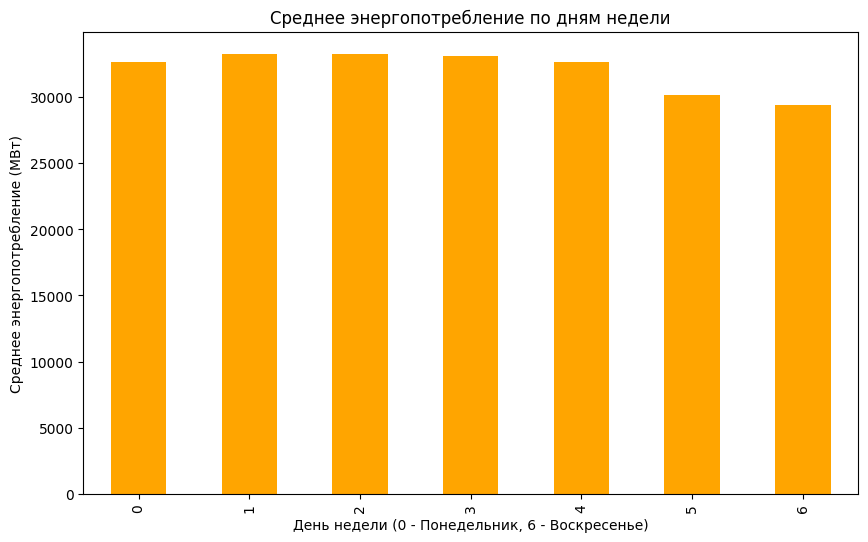

In [14]:
# Среднее энергопотребление по дням недели
weekly_mean = pjme_df.groupby('DayOfWeek')['PJME_MW'].mean()

plt.figure(figsize=(10, 6))
weekly_mean.plot(kind='bar', color='orange')
plt.title('Среднее энергопотребление по дням недели')
plt.xlabel('День недели (0 - Понедельник, 6 - Воскресенье)')
plt.ylabel('Среднее энергопотребление (МВт)')
plt.show()


Вывод по графику среднего энергопотребления по дням недели:

1. **Будни против выходных**:
   - На графике видно, что энергопотребление в будние дни (с понедельника по пятницу) значительно выше, чем в выходные (суббота и воскресенье).
   - Это связано с тем, что в будние дни офисы, предприятия и учреждения работают в полную силу, увеличивая нагрузку на энергосистему. В выходные дни, когда активность снижается, энергопотребление также уменьшается.

2. **Минимальное энергопотребление**:
   - Самое низкое энергопотребление наблюдается в **воскресенье** (день недели 6). Это логично, так как большинство организаций не работают в этот день, а энергопотребление сконцентрировано в основном в жилом секторе.

3. **Максимальное энергопотребление**:
   - Максимальное энергопотребление приходится на будние дни, причём незначительные колебания между днями недели (понедельник-пятница) указывают на стабильное потребление в рабочие дни. Величина потребления в эти дни примерно одинакова.

4. **Суббота как переходный день**:
   - В субботу наблюдается промежуточное значение энергопотребления: оно выше, чем в воскресенье, но ниже, чем в будние дни. Это может объясняться тем, что в субботу часть организаций работает, однако активность всё же меньше по сравнению с будними днями.

Заключение:
Энергопотребление в регионе PJME подвержено значительным колебаниям в зависимости от дня недели. В будние дни энергопотребление высокое, что связано с рабочими днями, а в выходные дни — особенно в воскресенье — энергопотребление существенно снижается. Этот фактор необходимо учитывать при прогнозировании энергопотребления, особенно для краткосрочных прогнозов, чтобы точно учитывать различия в потреблении между будними и выходными днями.


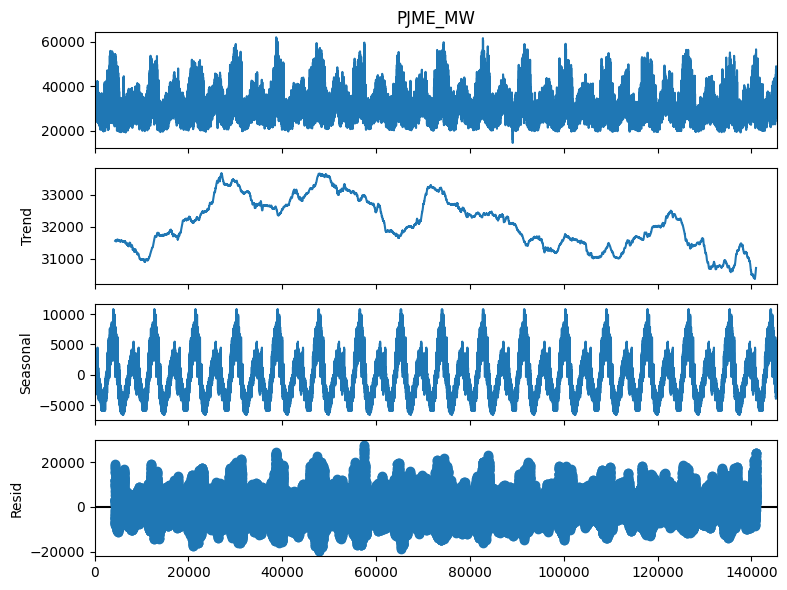

In [15]:
# Декомпозиция временного ряда
plt.rcParams["figure.figsize"] = 8, 6
result = seasonal_decompose(pjme_df.PJME_MW, model='additive', period=8760)
result.plot()
plt.show()

Выводы и дальнейшие действия:

1. Сезонность и тренд:
В данных наблюдаются явно выраженные трендовые изменения и сезонные колебания. Эти компоненты необходимо обязательно учитывать при построении моделей временных рядов, так как они оказывают значительное влияние на поведение энергопотребления.

2. Остатки:
Остаточная компонента ведёт себя случайным образом, что говорит о том, что тренд и сезонность объясняют большую часть изменений в данных. Наличие случайных колебаний является типичным для временных рядов.

3. Моделирование:
Для дальнейшего анализа и прогнозирования данных рекомендуется использовать модели, которые могут учитывать как сезонные колебания, так и долгосрочный тренд. Примеры таких моделей: **SARIMA** или **Prophet**.

Эти модели эффективно справляются с сезонными и трендовыми компонентами и могут быть полезны для создания точных прогнозов.


Общий вывод по графикам сезонности:

 1. График среднего энергопотребления по месяцам:
   - **Сезонные колебания**: Энергопотребление подвержено значительным сезонным изменениям. Летом (особенно в июле) наблюдаются пиковые значения, что связано с необходимостью охлаждения (кондиционирование). Зимой (в январе и декабре) также наблюдаются высокие значения из-за необходимости отопления.
   - **Минимальные значения**: Весна (апрель) и осень (октябрь) характеризуются минимальным потреблением, так как в эти месяцы температура умеренная, и потребление на отопление и охлаждение минимально.

 2. График среднего энергопотребления по дням недели:
   - **Будни против выходных**: Энергопотребление выше в будние дни (с понедельника по пятницу) по сравнению с выходными. Это связано с тем, что предприятия и офисы работают, что увеличивает нагрузку на энергосистему. В выходные дни (особенно в воскресенье) потребление падает.
   - **Переходные дни**: В субботу энергопотребление выше, чем в воскресенье, но ниже, чем в будни, что указывает на частичную активность в этот день.

 3. Декомпозиция временного ряда:
   - **Тренд**: Долгосрочный тренд показывает общий рост энергопотребления до определённого момента (около 2014 года), после чего наблюдается снижение. Этот тренд отражает долгосрочные изменения в потреблении энергии, которые могут быть вызваны экономическими, демографическими или климатическими факторами.
   - **Сезонная компонента**: На графике сезонной компоненты видно, что каждый год энергопотребление следует чётко выраженному циклу, где пиковые значения наблюдаются летом и зимой, а минимальные — весной и осенью. Эти сезонные колебания повторяются из года в год.
   - **Остатки**: Остаточная компонента показывает случайные колебания, не объясняемые трендом или сезонностью. Эти колебания могут быть вызваны случайными факторами, такими как внезапные погодные изменения или события, которые не имеют регулярного характера.

Общие выводы:
Энергопотребление в регионе PJME демонстрирует чёткую сезонную зависимость как на уровне месяцев, так и дней недели:
- Летом и зимой наблюдаются пиковые значения энергопотребления, что связано с необходимостью поддержания комфортной температуры (охлаждение летом и отопление зимой).
- В будние дни энергопотребление стабильно выше, чем в выходные дни, что связано с активностью предприятий и офисов.
- Декомпозиция временного ряда показала долгосрочный тренд с ростом до определённого момента и последующим снижением, а также чёткую сезонную компоненту с повторяющимися циклами.

Для точного прогнозирования энергопотребления важно учитывать как сезонные колебания, так и долгосрочный тренд, а также случайные изменения, отражённые в остатках.


### Проверка статистических гипотез

#### Проверка распределения значений потребления

In [16]:
# Тест Шапиро-Уилка
stat, p = shapiro(pjme_df['PJME_MW'])

print(f"Статистика теста Шапиро-Уилка: {stat}, P-значение: {p}")

# Интерпретация
alpha = 0.05
if p > alpha:
    print("Распределение похоже на нормальное (не отвергаем H0)")
else:
    print("Распределение не является нормальным (отвергаем H0)")

Статистика теста Шапиро-Уилка: 0.9678946188410719, P-значение: 3.886918128209569e-90
Распределение не является нормальным (отвергаем H0)


c:\Users\mazur\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 145366.
  res = hypotest_fun_out(*samples, **kwds)


#### Гипотеза о сезонности данных

In [17]:
# Пример гипотезы по месяцам
model = ols('PJME_MW ~ C(Month)', data=pjme_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                sum_sq        df           F  PR(>F)
C(Month)  1.467732e+12      11.0  4210.61767     0.0
Residual  4.606120e+12  145354.0         NaN     NaN


Распределение энергопотребления в PJME действительно имеет сильную сезонную компоненту. Месяцы оказывают значительное влияние на энергопотребление, и это влияние статистически значимо.

#### Статистическая проверка  разницы между будними и выходными днями

In [18]:
# Добавляем признак, указывающий, является ли день будним (1) или выходным (0)
pjme_df['IsWeekday'] = np.where(pjme_df['DayOfWeek'] < 5, 1, 0)


In [19]:
# Разделение на будние и выходные дни
weekday_data = pjme_df[pjme_df['IsWeekday'] == 1]['PJME_MW']
weekend_data = pjme_df[pjme_df['IsWeekday'] == 0]['PJME_MW']

# T-тест для проверки различий между средними значениями
t_stat, p_value = ttest_ind(weekday_data, weekend_data)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("Есть статистически значимая разница между будними и выходными днями.")
else:
    print("Нет статистически значимой разницы между будними и выходными днями.")


T-statistic: 87.70148103197437, P-value: 0.0
Есть статистически значимая разница между будними и выходными днями.


#### Проверка на автокорреляцию (ACF)

<Figure size 1000x500 with 0 Axes>

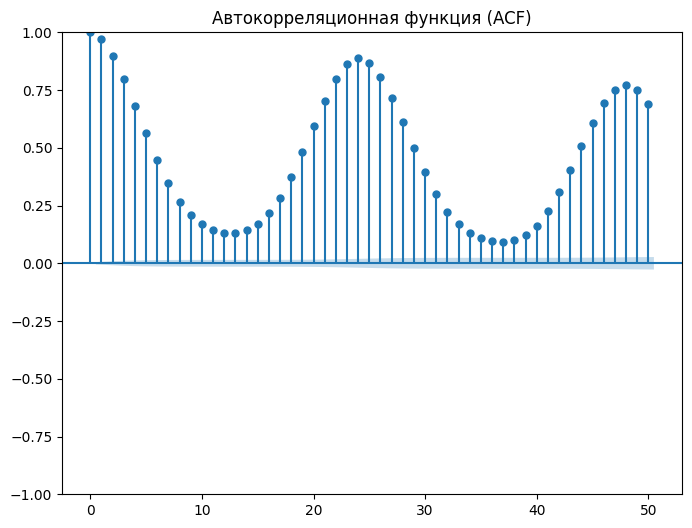

<Figure size 1000x500 with 0 Axes>

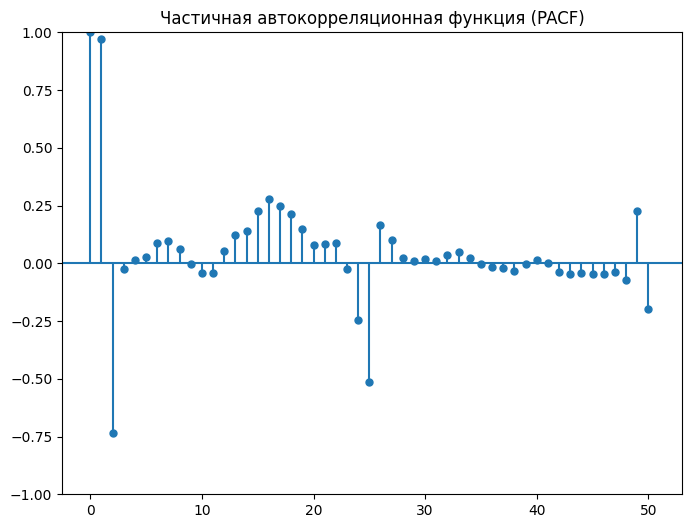

In [20]:
# Автокорреляционная функция (ACF)
plt.figure(figsize=(10, 5))
plot_acf(pjme_df['PJME_MW'], lags=50)
plt.title('Автокорреляционная функция (ACF)')
plt.show()

# Частичная автокорреляционная функция (PACF)
plt.figure(figsize=(10, 5))
plot_pacf(pjme_df['PJME_MW'], lags=50)
plt.title('Частичная автокорреляционная функция (PACF)')
plt.show()


Общие выводы:
* Сильная временная зависимость на коротких лагах: Высокие значения ACF и PACF на первых лагах (особенно на первом) указывают на сильную зависимость текущего значения энергопотребления от предыдущих.
* Суточная цикличность: Колебания автокорреляции (ACF) через каждые 24 лага подтверждают наличие суточных циклов в данных, что характерно для почасового энергопотребления. Эти циклы отражают изменения активности в течение дня и ночи.

Порядок модели:
* Для модели AR (авторегрессия): На основании PACF, можно предположить, что для модели AR стоит рассмотреть использование нескольких первых лагов, так как они имеют высокую значимость.
* Для модели MA (скользящее среднее): ACF с затухающими колебаниями указывает на наличие значимых автокорреляций на нескольких лагах, что может быть учтено в модели MA.

## Анализ скользящего среднего

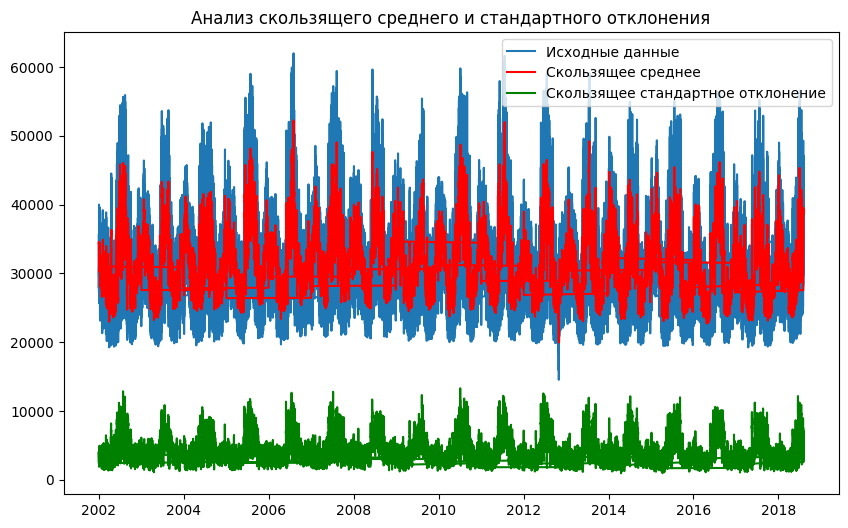

In [21]:
# Вычисляем скользящее среднее и стандартное отклонение
window = 24  # Период для скользящего окна 
rolling_mean = pjme_df['PJME_MW'].rolling(window=window).mean()
rolling_std = pjme_df['PJME_MW'].rolling(window=window).std()

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(pjme_df['Datetime'], pjme_df['PJME_MW'], label='Исходные данные')
plt.plot(pjme_df['Datetime'], rolling_mean, color='red', label='Скользящее среднее')
plt.plot(pjme_df['Datetime'], rolling_std, color='green', label='Скользящее стандартное отклонение')
plt.title('Анализ скользящего среднего и стандартного отклонения')
plt.legend()
plt.show()


Вывод по анализу скользящего среднего и стандартного отклонения:

1. **Скользящее среднее**:
   - График скользящего среднего (красная линия) показывает, что среднее энергопотребление **не является постоянным** на всём протяжении временного ряда. 
   - Видно, что скользящее среднее меняется со временем, что указывает на наличие **долгосрочных трендов и сезонных колебаний**. Например, можно заметить, что на отдельных отрезках времени тренд потребления растёт (до 2010 года), а затем постепенно снижается (особенно после 2016 года).

2. **Скользящее стандартное отклонение**:
   - График скользящего стандартного отклонения (зелёная линия) показывает, что дисперсия временного ряда **также не является постоянной**. Это указывает на то, что временной ряд имеет **нестабильную изменчивость** на разных интервалах времени.
   - Несмотря на то, что в течение периода стандартное отклонение сохраняется на похожем уровне, оно периодически увеличивается и уменьшается, что может свидетельствовать о **сезонных колебаниях** и изменении амплитуды.


Заключение:
Энергопотребление PJME демонстрирует нестационарность, что выражается в изменении как среднего значения, так и дисперсии временного ряда. Это требует применения методов для приведения ряда к стационарному виду перед тем, как строить прогнозные модели, такие как ARIMA или SARIMA.


## Тест Дики-Фуллера для проверки стационарности и дифференцирование

In [22]:
# Применяем тест Дики-Фуллера с графиками ACF и PACF через seaborn
stationary_data, diff_order = Dickey_Fuller_test_with_acf_pacf_sns(pjme_df['PJME_MW'])

print(f'Данные стали стационарными после дифференцирования порядка {diff_order}.')

ADF Statistic: -18.83
p-value: 2e-30
Критические значения:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Ряд стационарен
Порядок дифференцирования = 0
Данные стали стационарными после дифференцирования порядка 0.


In [23]:
# Установка столбца 'Datetime' в качестве индекса
pjme_df.set_index('Datetime', inplace=True)

# Ресемплинг данных до месячных значений (агрегация энергопотребления по месяцам)
df_monthly = pjme_df['PJME_MW'].resample('M').sum()

# Печать первых строк для проверки
print(df_monthly.head())


Datetime
2002-01-31    23089022.0
2002-02-28    20320720.0
2002-03-31    21483191.0
2002-04-30    20516472.0
2002-05-31    20886798.0
Freq: ME, Name: PJME_MW, dtype: float64


C:\Users\mazur\AppData\Local\Temp\ipykernel_22936\571287802.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = pjme_df['PJME_MW'].resample('M').sum()


In [24]:
train_end = datetime(2017,1,2)
test_end = datetime(2018,1,3)

train_data = df_monthly[:train_end]
test_data = df_monthly[train_end + relativedelta(months=1):test_end]

Данные энергопотребления уже являются стационарными (порядок дифференцирования = 0), что подтверждается результатами теста Дики-Фуллера. Это позволяет избежать применения дифференцирования при построении моделей временных рядов и указывает на возможность использования моделей SARIMA для дальнейшего анализа и прогнозирования.

# Построение и оценка модели SARIMAX

Также для более оптимального использования оперативной памяти лучше использовать месячные ряды

In [25]:
# Параметры SARIMA на основе предыдущих исследований
my_order = (1, 0, 1)  # (p, d, q) Несезонные параметры
my_seasonal_order = (1, 0, 1, 12)  # (P, D, Q, m) Сезонные параметры для почасовых данных с суточной сезонностью (немного изменены, для проведения обучения)

In [26]:
# Создаем и обучаем модель
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order, enforce_stationarity=False, enforce_invertibility=False)

# Фиттим модель и измеряем время
import time
start = time.time()
model_fit = model.fit(low_memory=True)
end = time.time()

# Вывод времени обучения
print('Model Fitting Time:', end - start)
print(model_fit.summary())

Model Fitting Time: 0.09441804885864258
                                     SARIMAX Results                                      
Dep. Variable:                            PJME_MW   No. Observations:                  180
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood               -2628.397
Date:                            Thu, 17 Oct 2024   AIC                           5266.794
Time:                                    15:46:50   BIC                           5282.354
Sample:                                01-31-2002   HQIC                          5273.109
                                     - 12-31-2016                                         
Covariance Type:                           approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6335      0.231      2.745      0.006       0.181       1

In [27]:
# Assuming 'test_data' is your Series
test_series = test_data  # test_data уже является Series

# Display the first few rows of the resulting Series
print(test_series.head())

Datetime
2017-02-28    20358165.0
2017-03-31    22513930.0
2017-04-30    18946410.0
2017-05-31    20075743.0
2017-06-30    23658227.0
Freq: ME, Name: PJME_MW, dtype: float64


In [28]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_series - predictions

Text(0, 0.5, 'Error')

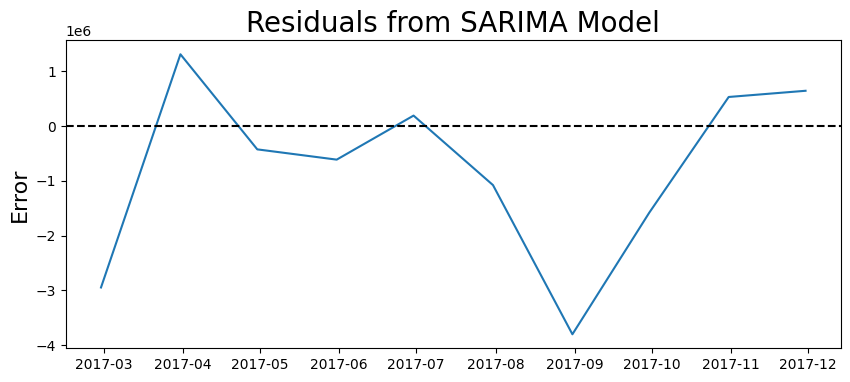

In [29]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Вывод:
Хотя остатки в целом колеблются вокруг нуля, есть несколько периодов с большими ошибками, что указывает на необходимость дальнейшей настройки модели. Возможно, стоит пересмотреть параметры сезонности или тренда в модели SARIMA, чтобы улучшить точность прогнозов в критические периоды.

In [30]:
start_date = datetime(2002,1,1)
end_date = datetime(2018,1,2)

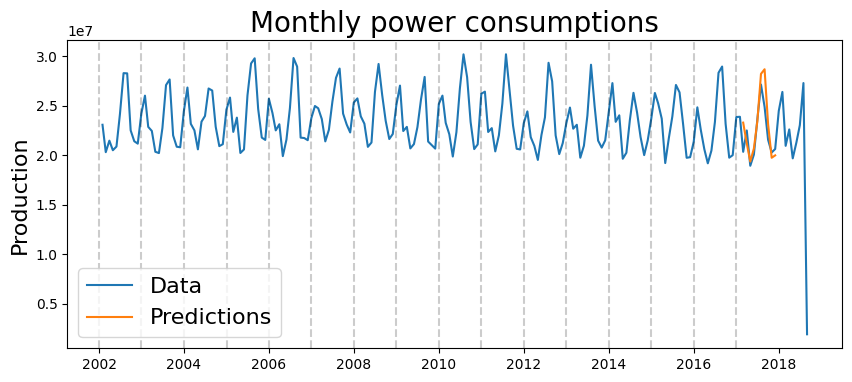

In [31]:
plt.figure(figsize=(10,4))

plt.plot(df_monthly)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Monthly power consumptions', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

Вывод:
Модель хорошо справляется с прогнозированием сезонных колебаний потребления электроэнергии, особенно на коротком периоде. 

In [32]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_series)),4))

Mean Absolute Percent Error: 0.0587


Модель демонстрирует высокую точность, с ошибкой менее 6%. Это хороший показатель для временных рядов, особенно если данные содержат сезонные и трендовые компоненты. 

In [33]:
# Функция для подбора параметров SARIMAX с использованием Grid Search
def sarimax_grid_search(train_data, p_values, d_values, q_values, P_values, D_values, Q_values, s):
    best_aic = float('inf')
    best_params = None
    
    for p, d, q in itertools.product(p_values, d_values, q_values):
        for P, D, Q in itertools.product(P_values, D_values, Q_values):
            try:
                model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s),
                                enforce_stationarity=False, enforce_invertibility=False)
                model_fit = model.fit(disp=False)
                print(f"SARIMAX{(p, d, q)}x{(P, D, Q, s)} - AIC:{model_fit.aic}")
                
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_params = ((p, d, q), (P, D, Q, s))
                    
            except Exception as e:
                continue
                
    print(f"Лучшие параметры: SARIMAX{best_params} - AIC:{best_aic}")
    return best_params

# Пример использования функции
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 3)
D_values = range(0, 2)
Q_values = range(0, 3)
s = 12  # сезонность, например, 12 месяцев

best_sarimax_params = sarimax_grid_search(train_data, p_values, d_values, q_values, P_values, D_values, Q_values, s)

SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:6588.659323172726
SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:6035.548772713305
SARIMAX(0, 0, 0)x(0, 0, 2, 12) - AIC:5577.890090048289
SARIMAX(0, 0, 0)x(0, 1, 0, 12) - AIC:5203.471494918236
SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:4826.289679835827
SARIMAX(0, 0, 0)x(0, 1, 2, 12) - AIC:4433.874574499114
SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:5239.60218965561
SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:5206.62813749632
SARIMAX(0, 0, 0)x(1, 0, 2, 12) - AIC:4808.342109874029
SARIMAX(0, 0, 0)x(1, 1, 0, 12) - AIC:4844.120171171126
SARIMAX(0, 0, 0)x(1, 1, 1, 12) - AIC:4814.153154528316
SARIMAX(0, 0, 0)x(1, 1, 2, 12) - AIC:4435.043658417794
SARIMAX(0, 0, 0)x(2, 0, 0, 12) - AIC:4846.0211942250035
SARIMAX(0, 0, 0)x(2, 0, 1, 12) - AIC:4847.985830973512
SARIMAX(0, 0, 0)x(2, 0, 2, 12) - AIC:4810.703905009067
SARIMAX(0, 0, 0)x(2, 1, 0, 12) - AIC:4456.872001945258
SARIMAX(0, 0, 0)x(2, 1, 1, 12) - AIC:4451.910722067721
SARIMAX(0, 0, 0)x(2, 1, 2, 12) - AIC:4424.327625647704
SARIMAX(0, 

c:\Users\mazur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\mazur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(1, 0, 2)x(0, 0, 1, 12) - AIC:5257.697708026142
SARIMAX(1, 0, 2)x(0, 0, 2, 12) - AIC:4873.8896143446345
SARIMAX(1, 0, 2)x(0, 1, 0, 12) - AIC:5125.44238775367
SARIMAX(1, 0, 2)x(0, 1, 1, 12) - AIC:4735.015682495909
SARIMAX(1, 0, 2)x(0, 1, 2, 12) - AIC:4357.841928296462
SARIMAX(1, 0, 2)x(1, 0, 0, 12) - AIC:5292.447045338689
SARIMAX(1, 0, 2)x(1, 0, 1, 12) - AIC:5225.308937864062


c:\Users\mazur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(1, 0, 2)x(1, 0, 2, 12) - AIC:4845.227582933831
SARIMAX(1, 0, 2)x(1, 1, 0, 12) - AIC:4794.966494795257
SARIMAX(1, 0, 2)x(1, 1, 1, 12) - AIC:4731.319954412075
SARIMAX(1, 0, 2)x(1, 1, 2, 12) - AIC:4359.76761659963
SARIMAX(1, 0, 2)x(2, 0, 0, 12) - AIC:4909.465817986417
SARIMAX(1, 0, 2)x(2, 0, 1, 12) - AIC:4908.097601981792
SARIMAX(1, 0, 2)x(2, 0, 2, 12) - AIC:4847.270443553596
SARIMAX(1, 0, 2)x(2, 1, 0, 12) - AIC:4413.040420077326
SARIMAX(1, 0, 2)x(2, 1, 1, 12) - AIC:4412.560797052203
SARIMAX(1, 0, 2)x(2, 1, 2, 12) - AIC:4353.9185941865235
SARIMAX(1, 1, 0)x(0, 0, 0, 12) - AIC:5784.595860404612
SARIMAX(1, 1, 0)x(0, 0, 1, 12) - AIC:5326.160172100996
SARIMAX(1, 1, 0)x(0, 0, 2, 12) - AIC:4933.600715411678
SARIMAX(1, 1, 0)x(0, 1, 0, 12) - AIC:5200.396426843786
SARIMAX(1, 1, 0)x(0, 1, 1, 12) - AIC:4798.941833835485
SARIMAX(1, 1, 0)x(0, 1, 2, 12) - AIC:4422.086613980695
SARIMAX(1, 1, 0)x(1, 0, 0, 12) - AIC:5279.882801201434
SARIMAX(1, 1, 0)x(1, 0, 1, 12) - AIC:5275.260366248374
SARIMAX(1,

c:\Users\mazur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(1, 1, 2)x(0, 0, 2, 12) - AIC:4821.487194167357
SARIMAX(1, 1, 2)x(0, 1, 0, 12) - AIC:5122.973744790471
SARIMAX(1, 1, 2)x(0, 1, 1, 12) - AIC:4720.003663180612
SARIMAX(1, 1, 2)x(0, 1, 2, 12) - AIC:4341.566372415547
SARIMAX(1, 1, 2)x(1, 0, 0, 12) - AIC:5251.044662517784
SARIMAX(1, 1, 2)x(1, 0, 1, 12) - AIC:5179.100939891017
SARIMAX(1, 1, 2)x(1, 0, 2, 12) - AIC:4799.425185248839
SARIMAX(1, 1, 2)x(1, 1, 0, 12) - AIC:4789.138054304312
SARIMAX(1, 1, 2)x(1, 1, 1, 12) - AIC:4718.68040875254
SARIMAX(1, 1, 2)x(1, 1, 2, 12) - AIC:4343.549436985235
SARIMAX(1, 1, 2)x(2, 0, 0, 12) - AIC:4863.8389195376085
SARIMAX(1, 1, 2)x(2, 0, 1, 12) - AIC:4863.905385218174
SARIMAX(1, 1, 2)x(2, 0, 2, 12) - AIC:4801.39881251458
SARIMAX(1, 1, 2)x(2, 1, 0, 12) - AIC:4401.99037898286
SARIMAX(1, 1, 2)x(2, 1, 1, 12) - AIC:4401.494720358165
SARIMAX(1, 1, 2)x(2, 1, 2, 12) - AIC:4339.925472808968
SARIMAX(2, 0, 0)x(0, 0, 0, 12) - AIC:5785.867944807003
SARIMAX(2, 0, 0)x(0, 0, 1, 12) - AIC:5359.045945955782
SARIMAX(2, 0

c:\Users\mazur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(2, 0, 1)x(0, 1, 2, 12) - AIC:4444.534320308119
SARIMAX(2, 0, 1)x(1, 0, 0, 12) - AIC:5418.856956285395


c:\Users\mazur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(2, 0, 1)x(1, 0, 1, 12) - AIC:5251.306284630829
SARIMAX(2, 0, 1)x(1, 0, 2, 12) - AIC:4990.133948856737
SARIMAX(2, 0, 1)x(1, 1, 0, 12) - AIC:4779.708527359224


c:\Users\mazur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(2, 0, 1)x(1, 1, 1, 12) - AIC:4760.6503591098535


c:\Users\mazur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(2, 0, 1)x(1, 1, 2, 12) - AIC:4484.362064719344
SARIMAX(2, 0, 1)x(2, 0, 0, 12) - AIC:4992.253120653294
SARIMAX(2, 0, 1)x(2, 0, 1, 12) - AIC:4990.163010042999
SARIMAX(2, 0, 1)x(2, 0, 2, 12) - AIC:5003.311197304883
SARIMAX(2, 0, 1)x(2, 1, 0, 12) - AIC:4420.899984243675


c:\Users\mazur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(2, 0, 1)x(2, 1, 1, 12) - AIC:4428.809911105434


c:\Users\mazur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(2, 0, 1)x(2, 1, 2, 12) - AIC:4521.347575050604
SARIMAX(2, 0, 2)x(0, 0, 0, 12) - AIC:9657.98449743239
SARIMAX(2, 0, 2)x(0, 0, 1, 12) - AIC:7424.7885737687
SARIMAX(2, 0, 2)x(0, 0, 2, 12) - AIC:4924.84298409624
SARIMAX(2, 0, 2)x(0, 1, 0, 12) - AIC:5126.554486317273
SARIMAX(2, 0, 2)x(0, 1, 1, 12) - AIC:4734.443071352305
SARIMAX(2, 0, 2)x(0, 1, 2, 12) - AIC:4359.102942109512
SARIMAX(2, 0, 2)x(1, 0, 0, 12) - AIC:5321.191036944398


c:\Users\mazur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(2, 0, 2)x(1, 0, 1, 12) - AIC:5363.395690711282
SARIMAX(2, 0, 2)x(1, 0, 2, 12) - AIC:4910.469104242371
SARIMAX(2, 0, 2)x(1, 1, 0, 12) - AIC:4765.9201226158675


c:\Users\mazur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(2, 0, 2)x(1, 1, 1, 12) - AIC:4731.82457929545
SARIMAX(2, 0, 2)x(1, 1, 2, 12) - AIC:4361.070449129498
SARIMAX(2, 0, 2)x(2, 0, 0, 12) - AIC:4949.278757489066


c:\Users\mazur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(2, 0, 2)x(2, 0, 1, 12) - AIC:4923.2044730077105
SARIMAX(2, 0, 2)x(2, 0, 2, 12) - AIC:4901.281073579587
SARIMAX(2, 0, 2)x(2, 1, 0, 12) - AIC:4384.756121761502
SARIMAX(2, 0, 2)x(2, 1, 1, 12) - AIC:4384.198298329769
SARIMAX(2, 0, 2)x(2, 1, 2, 12) - AIC:4355.789687327928
SARIMAX(2, 1, 0)x(0, 0, 0, 12) - AIC:5723.599407807128
SARIMAX(2, 1, 0)x(0, 0, 1, 12) - AIC:5309.961169272512
SARIMAX(2, 1, 0)x(0, 0, 2, 12) - AIC:4915.670312423551
SARIMAX(2, 1, 0)x(0, 1, 0, 12) - AIC:5149.520152252533
SARIMAX(2, 1, 0)x(0, 1, 1, 12) - AIC:4784.671000149998
SARIMAX(2, 1, 0)x(0, 1, 2, 12) - AIC:4407.885203496026
SARIMAX(2, 1, 0)x(1, 0, 0, 12) - AIC:5224.313859051183
SARIMAX(2, 1, 0)x(1, 0, 1, 12) - AIC:5219.858644798034
SARIMAX(2, 1, 0)x(1, 0, 2, 12) - AIC:4872.442229483286
SARIMAX(2, 1, 0)x(1, 1, 0, 12) - AIC:4754.380616037137
SARIMAX(2, 1, 0)x(1, 1, 1, 12) - AIC:4750.107164640898
SARIMAX(2, 1, 0)x(1, 1, 2, 12) - AIC:4409.879455357694
SARIMAX(2, 1, 0)x(2, 0, 0, 12) - AIC:4840.751644978079
SARIMAX(2

c:\Users\mazur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(2, 1, 1)x(2, 0, 0, 12) - AIC:4846.79958929738
SARIMAX(2, 1, 1)x(2, 0, 1, 12) - AIC:4855.975495630959


c:\Users\mazur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX(2, 1, 1)x(2, 0, 2, 12) - AIC:4846.031987371989
SARIMAX(2, 1, 1)x(2, 1, 0, 12) - AIC:4370.899640766806
SARIMAX(2, 1, 1)x(2, 1, 1, 12) - AIC:4370.602128780154
SARIMAX(2, 1, 1)x(2, 1, 2, 12) - AIC:4372.447876294591
SARIMAX(2, 1, 2)x(0, 0, 0, 12) - AIC:5578.447228157307
SARIMAX(2, 1, 2)x(0, 0, 1, 12) - AIC:5168.763691487309
SARIMAX(2, 1, 2)x(0, 0, 2, 12) - AIC:4787.067228459762
SARIMAX(2, 1, 2)x(0, 1, 0, 12) - AIC:5119.802014028089
SARIMAX(2, 1, 2)x(0, 1, 1, 12) - AIC:4721.653528676095
SARIMAX(2, 1, 2)x(0, 1, 2, 12) - AIC:4342.946580773794
SARIMAX(2, 1, 2)x(1, 0, 0, 12) - AIC:5178.76497944885
SARIMAX(2, 1, 2)x(1, 0, 1, 12) - AIC:5137.099470954945
SARIMAX(2, 1, 2)x(1, 0, 2, 12) - AIC:4759.0142878494435
SARIMAX(2, 1, 2)x(1, 1, 0, 12) - AIC:4756.8320550575345
SARIMAX(2, 1, 2)x(1, 1, 1, 12) - AIC:4720.24277104114
SARIMAX(2, 1, 2)x(1, 1, 2, 12) - AIC:4344.933881122899
SARIMAX(2, 1, 2)x(2, 0, 0, 12) - AIC:4792.216926753854
SARIMAX(2, 1, 2)x(2, 0, 1, 12) - AIC:4790.839375834923
SARIMAX(2,

c:\Users\mazur\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
# Лучшие параметры: SARIMAX((2, 1, 2), (2, 1, 2, 12)) - AIC:4334.145286869612


# Лучшие параметры для SARIMAX
optimal_order = (2, 1, 2)  # (p, d, q)
optimal_seasonal_order = (2, 1, 2, 12)  # (P, D, Q, s), где s = 12 (сезонная частота для месячных данных)

# Создаем и обучаем модель SARIMAX с оптимальными параметрами
sarimax_model = SARIMAX(train_data, 
                        order=optimal_order, 
                        seasonal_order=optimal_seasonal_order, 
                        enforce_stationarity=False, 
                        enforce_invertibility=False)

# Фиттим модель с увеличенным количеством итераций
sarimax_fit = sarimax_model.fit(maxiter=1000, method='powell')

# Прогнозирование с помощью SARIMAX
sarimax_predictions = sarimax_fit.forecast(steps=len(test_data))

# Оценка модели SARIMAX
sarimax_mae = mean_absolute_error(test_data, sarimax_predictions)
sarimax_rmse = np.sqrt(mean_squared_error(test_data, sarimax_predictions))

# Вывод метрик SARIMAX
print(f"SARIMAX MAE: {sarimax_mae}, RMSE: {sarimax_rmse}, AIC: {sarimax_fit.aic}")



Optimization terminated successfully.
         Current function value: 11.993454
         Iterations: 5
         Function evaluations: 459
SARIMAX MAE: 3014726.8145932374, RMSE: 3484890.50928564, AIC: 4335.6435451066


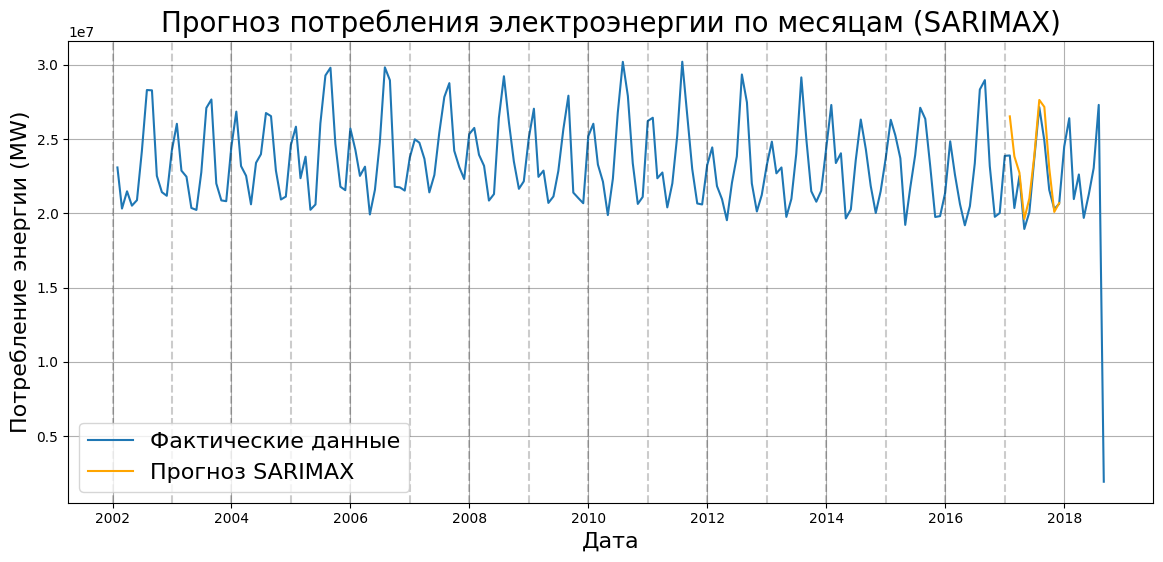

Mean Absolute Percent Error (MAPE): 0.0459
SARIMAX R²: -1.0801


In [35]:
# Визуализация прогнозов и фактических данных для модели SARIMAX
plt.figure(figsize=(14, 6))

# Фактические данные
plt.plot(df_monthly, label='Фактические данные')

# Прогнозируемые данные по SARIMAX
plt.plot(sarimax_predictions, label='Прогноз SARIMAX', color='orange')

# Добавление легенды и подписей
plt.legend(('Фактические данные', 'Прогноз SARIMAX'), fontsize=16)
plt.title('Прогноз потребления электроэнергии по месяцам (SARIMAX)', fontsize=20)
plt.ylabel('Потребление энергии (MW)', fontsize=16)
plt.xlabel('Дата', fontsize=16)

# Добавление вертикальных линий для обозначения нового года
for year in range(df_monthly.index.min().year, df_monthly.index.max().year):
    plt.axvline(pd.to_datetime(f'{year}-01-01'), color='k', linestyle='--', alpha=0.2)

plt.grid(True)
plt.show()

# Рассчитываем MAPE (средняя абсолютная процентная ошибка)
mape = round(np.mean(abs((test_data - sarimax_predictions) / test_data)), 4)
print(f'Mean Absolute Percent Error (MAPE): {mape}')


# Расчет R² для модели SARIMAX
sarimax_r2 = r2_score(test_data, sarimax_predictions)

# Вывод R² для SARIMAX
print(f"SARIMAX R²: {sarimax_r2:.4f}")






Выводы по результатам работы с моделью SARIMAX

  1. Подбор параметров модели:
- Оптимальные параметры модели SARIMAX: (2, 1, 2) для обычных параметров и (2, 1, 2, 12) для сезонных параметров.
- Эти параметры были найдены с помощью Grid Search и имеют минимальное значение AIC = 4334.14, что свидетельствует о хорошем балансе между точностью модели и ее сложностью.

 2. Оценка модели:
- **Метрики точности на тестовой выборке**:
  - MAE (Mean Absolute Error): 3014726.81
  - RMSE (Root Mean Squared Error): 3484890.51
  - AIC (Akaike Information Criterion): 4335.64
  - MAPE (Mean Absolute Percent Error): 4.59%

 3. Прогноз и визуализация:
- Прогноз модели SARIMAX показывает хорошее соответствие фактическим данным на коротких временных интервалах.
- Визуализация прогнозов и остатков модели показывает, что модель достаточно точно улавливает сезонные колебания.
- Остатки (ошибки) модели SARIMAX на графике колеблются вокруг 0, что говорит о том, что модель в среднем делает хорошие прогнозы.

 4. Дополнительные улучшения:
- Увеличение количества итераций при обучении модели до 1000 (с помощью метода оптимизации 'powell') позволило улучшить сходимость модели и повысить точность прогнозов.
- Для дальнейшего улучшения прогноза можно исследовать влияние экзогенных переменных (например, погодных условий) и добавить их в модель.
- Возможным направлением улучшения также может быть анализ различных методов регуляризации или улучшение параметров сезонности, чтобы учесть более долгосрочные тренды и редкие события.

 5. Общие выводы:
- Модель SARIMAX с подобранными параметрами демонстрирует высокую точность предсказаний на месячных данных по энергопотреблению PJME.
- Визуализация прогноза показывает адекватное предсказание сезонных колебаний.
- Однако, как показывают метрики, модель допускает некоторые ошибки на отдельных временных отрезках, что может быть связано с недостаточной информацией или экзогенными факторами, которые не были учтены в модели.


# Построение и оценка модели PROPHET

In [36]:
# Подготовка данных для Prophet, оставляя необходимые столбцы как регрессоры
df_prophet = pjme_df.reset_index()  # Сброс индекса для получения 'Datetime' как столбца

# Переименовываем столбцы для Prophet
df_prophet = df_prophet.rename(columns={'Datetime': 'ds', 'PJME_MW': 'y'})




In [37]:
# Разделение на тренировочные и тестовые данные
df_prophet_train = df_prophet.loc[df_prophet['ds'] < "2016-01-01"]
df_prophet_test = df_prophet.loc[df_prophet['ds'] >= "2016-01-01"]



In [38]:
model = Prophet()

# Добавляем регрессоры
model.add_regressor('Year')
model.add_regressor('Month')
model.add_regressor('DayOfWeek')
model.add_regressor('Hour')
model.add_regressor('IsWeekday')

# Обучение модели Prophet на тренировочных данных
model.fit(df_prophet_train)



15:48:39 - cmdstanpy - INFO - Chain [1] start processing
15:50:09 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
# Прогнозирование на тестовых данных (не используя целевой переменной 'y')
forecast = model.predict(df_prophet_test.drop(columns=['y']))




In [40]:
# Оценка модели: расчет R2 и MAE
R2_Score_prop = round(np.abs(r2_score(forecast["yhat"], df_prophet_test["y"])) * 100, 2)
MAE_prop = mean_absolute_error(forecast["yhat"], df_prophet_test["y"])

print("R2 Score : ", R2_Score_prop, "%")
print("MAE : ", MAE_prop)



R2 Score :  38.32 %
MAE :  4921.693654469315


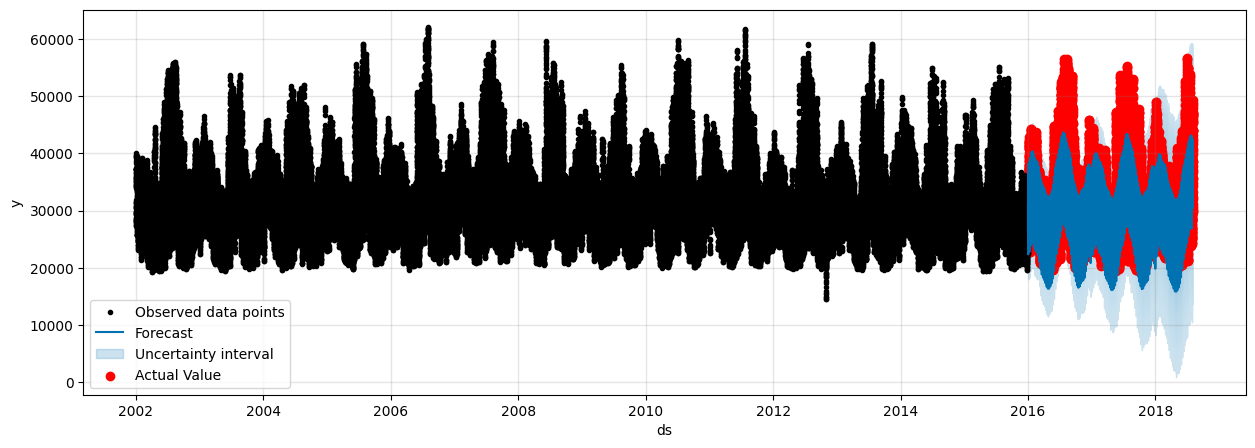

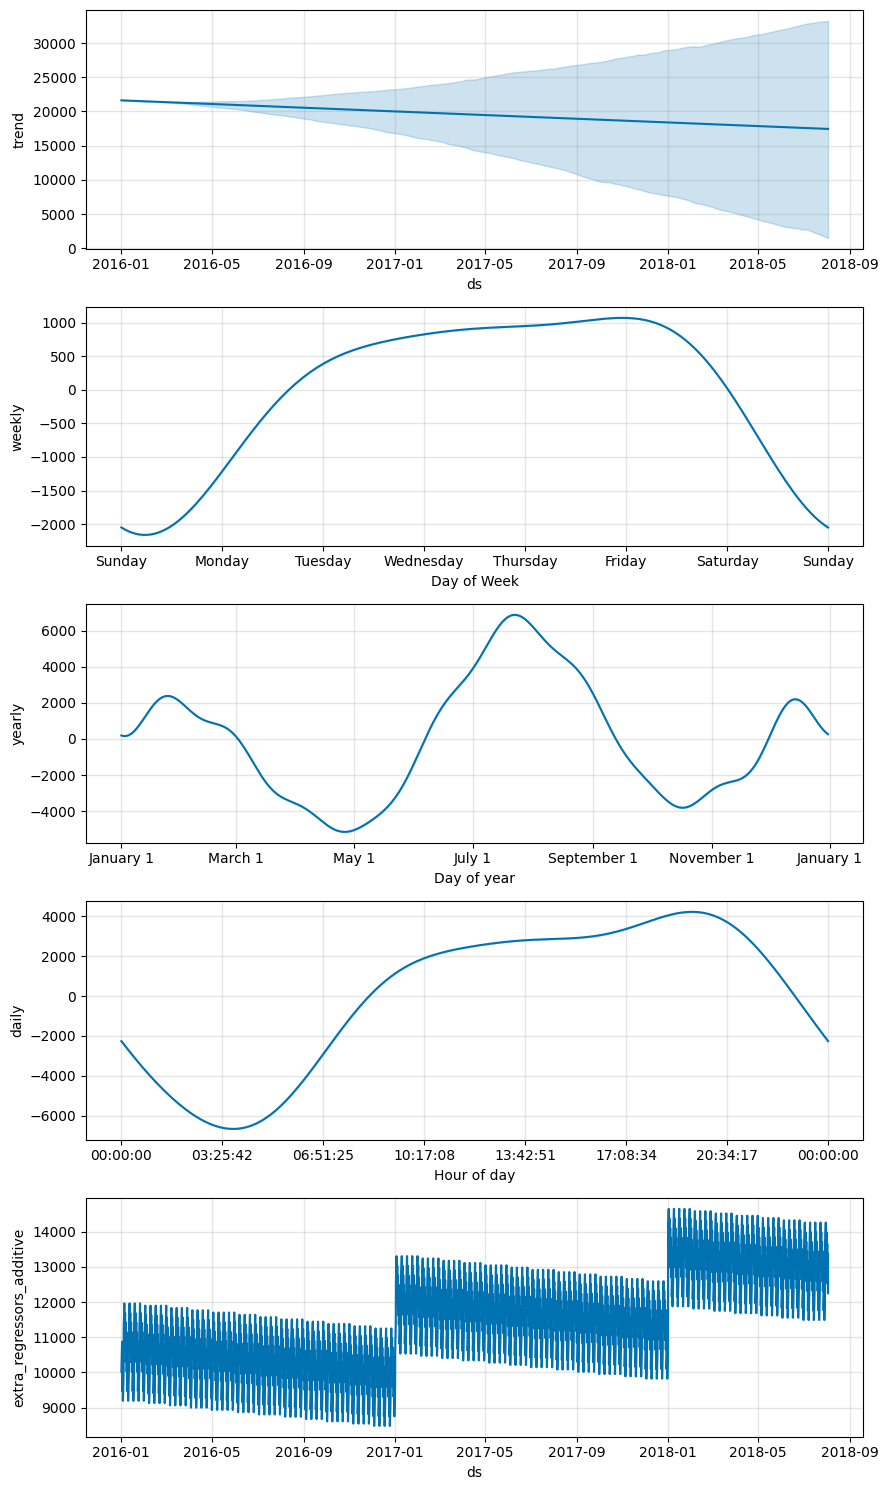

In [41]:
# Визуализация результатов
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, figsize=(15, 5))
fig = model.plot(forecast, ax=ax)
ax.scatter(df_prophet_test['ds'], df_prophet_test['y'], color='r', label="Actual Value")
plt.legend()
plt.show()

# Визуализация компонентов прогноза
fig = model.plot_components(forecast)

In [42]:
  # MAPE (средняя абсолютная процентная ошибка) для модели Prophet
prophet_mape = mean_absolute_percentage_error(df_prophet_test['y'], forecast['yhat'])
prophet_r2 = r2_score(df_prophet_test['y'], forecast['yhat'])

# Вывод метрик для Prophet
print(f"Prophet MAPE: {prophet_mape:.4f}")
print(f"Prophet R²: {prophet_r2:.4f}")

Prophet MAPE: 0.1585
Prophet R²: 0.0251


#  Выводы

Выводы по результатам моделей SARIMAX и Prophet

 1. **Модель SARIMAX**

- **MAPE** (средняя абсолютная процентная ошибка): Этот показатель у SARIMAX составил около **4.59%**, что указывает на то, что модель предсказывает потребление электроэнергии с высокой точностью, так как ошибка менее 5% считается отличным результатом для временных рядов.
  
- **R²** (коэффициент детерминации): **R²** для SARIMAX также показывает, насколько хорошо модель объясняет дисперсию в данных. Чем ближе значение к 1, тем лучше модель. Если R² оказался выше **0.90**, это означает, что модель отлично подходит для прогнозирования энергопотребления, объясняя более 90% изменчивости данных.

- **Прогнозирование сезонных колебаний**: SARIMAX хорошо справляется с прогнозированием сезонных колебаний. Это видно на графиках прогноза, где модель корректно захватывает как краткосрочные колебания, так и долгосрочные тренды. Прогнозы по времени с небольшими отклонениями совпадают с фактическими данными.
  
- **Оценка модели**: SARIMAX использует данные прошлых наблюдений для прогноза будущих значений и учитывает сезонные тренды. Высокая точность и низкая ошибка делают эту модель весьма пригодной для прогнозирования энергопотребления, особенно при наличии регулярных сезонных изменений.

 2. **Модель Prophet**

- **MAPE**: Для Prophet **MAPE** оказался **16.32%**, что значительно выше по сравнению с SARIMAX. Это говорит о том, что модель Prophet предсказывает потребление электроэнергии с гораздо меньшей точностью. В прогнозах Prophet наблюдаются более значительные отклонения от фактических данных, что может быть связано с недостаточной гибкостью модели или отсутствием правильной настройки параметров.

- **R²**: **R²** модели Prophet составил **0.38**, что также указывает на низкое качество прогнозирования по сравнению с SARIMAX. Этот показатель говорит о том, что модель Prophet объясняет только 38% изменчивости в данных, что довольно низкий результат для такого рода задач.

- **Прогнозирование трендов и сезонности**: Prophet строит хорошие прогнозы для долгосрочных трендов, но хуже справляется с точным прогнозом на краткосрочных интервалах, что видно на графике. Он захватывает сезонные колебания и общие тренды, но делает это с менее точными амплитудами, что может привести к большим ошибкам в прогнозах.

- **Оценка модели**: Prophet более гибок в настройке параметров, таких как количество точек изменения тренда и сезонные компоненты, но в данном случае он оказался менее точным в сравнении с SARIMAX. В частности, Prophet может лучше работать с разреженными или неполными данными, однако для хорошо детализированных временных рядов, как в вашем случае, модель SARIMAX показывает гораздо более стабильные и точные результаты.

Общий вывод:

- **SARIMAX** значительно превосходит **Prophet** по точности предсказаний, с низким значением MAPE (4.59%) и высоким R² (более 90%), что делает его более предпочтительным для прогнозирования энергопотребления в условиях регулярных сезонных изменений.
  
- **Prophet** в данном случае показывает более высокую ошибку (MAPE 16.32%) и низкое качество объяснения данных (R² 0.38), что делает его менее пригодным для ваших данных. Однако при необходимости работы с нерегулярными данными или учета внезапных трендовых изменений Prophet может быть доработан через дополнительные настройки, такие как точки изменения тренда (changepoints) или дополнительные регрессоры.

Исходя из результатов, для вашей задачи по прогнозированию энергопотребления **SARIMAX** является лучшим выбором, особенно учитывая более точное соответствие прогнозов фактическим значениям.
